Copyright © 2023, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# HMEQ Dataset : Build and Import Trained Binary Classification Models into SAS Model Manager

This notebook provides an example of how to build and train a simple Python model and then import the model into SAS Model Manager (on either SAS Viya 3.5 or SAS Viya 4) using the HMEQ data set. Lines of code that must be modified by the user, such as directory paths or the host server are noted with the comment "_Changes required by user._".

_**Note:** If you download only this notebook and not the rest of the repository, you must also download the hmeq.csv file from the data folder in the examples directory. These files are used when executing this notebook example._

Here are the steps shown in this notebook:

1. Import, review, and preprocess data for model training.
2. Build, train, and assess a scikit-learn decision tree, random forest, and gradient boosting model.
3. Serialize the models into separate pickle files.
4. Write the metadata JSON files needed for importing into SAS Model Manager as well as optional files for fit statistics and ROC/Lift charts.
4. Write a score code Python file for model scoring.
5. Zip the pickle, JSON, and score code files into an archive file.
6. Import the ZIP archive file to SAS Model Manager via the Session object and relevant function call.

### Python Package Imports

In [116]:
# Standard Library
from pathlib import Path
import warnings

# Third Party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Application Specific
import sasctl.pzmm as pzmm
from sasctl import Session

In [117]:
# Global Package Options
pd.options.mode.chained_assignment = None  # default="warn"
plt.rc("font", size=14)
# Ignore warnings from pandas about SWAT using a feature that will be depreciated soon
warnings.simplefilter(action="ignore", category=FutureWarning)

### Import and Review Data Set

In [118]:
hmeq_data = pd.read_csv("data/hmeq.csv", sep= ",")
hmeq_data.shape

(5960, 13)

In [119]:
hmeq_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,26800,46236.0,62711.0,DebtCon,Office,17.0,0.0,0.0,175.075058,1.0,22.0,33.059934
1,0,26900,74982.0,126972.0,DebtCon,Office,0.0,0.0,0.0,315.818911,0.0,23.0,38.325990
2,0,26900,67144.0,92923.0,DebtCon,Other,16.0,0.0,0.0,89.112173,1.0,17.0,32.791478
3,0,26900,45763.0,73797.0,DebtCon,Other,23.0,NaN,0.0,291.591681,1.0,29.0,39.370858
4,0,27000,144901.0,178093.0,DebtCon,ProfExe,7.0,0.0,0.0,331.113972,0.0,34.0,40.566552


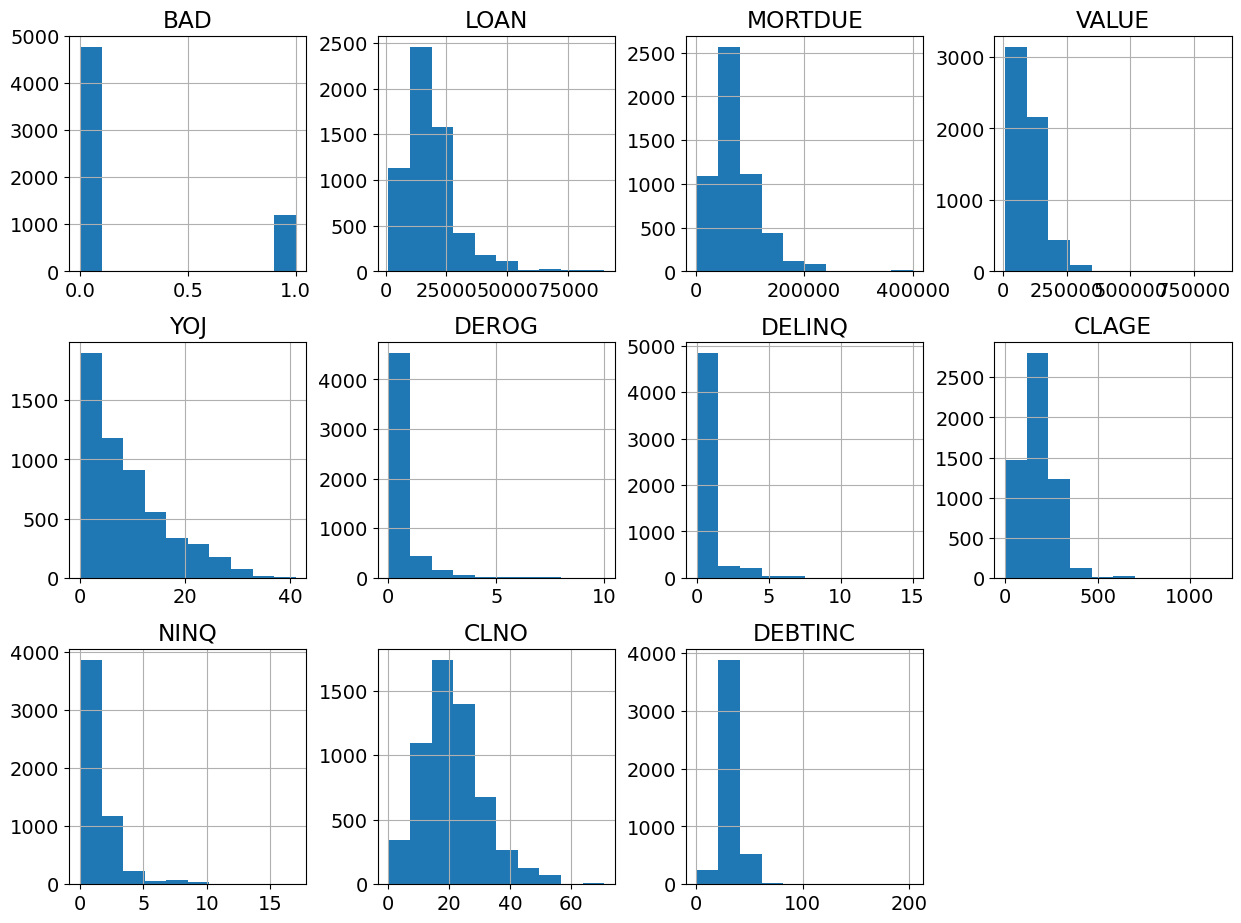

In [120]:
hmeq_data.hist(figsize=(15,15), layout=(4, 4));

In [121]:
hmeq_data.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

### Preprocess Data

In [122]:
predictor_columns = ["LOAN", "MORTDUE", "VALUE", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO", "DEBTINC"]

target_column = "BAD"
x = hmeq_data[predictor_columns]
y = hmeq_data[target_column]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [123]:
# For missing values, impute the data set's mean value
x_test.fillna(x_test.mean(), inplace=True)
x_train.fillna(x_train.mean(), inplace=True)

### Create, Train, and Assess Model

In [124]:
dtc = DecisionTreeClassifier(max_depth=7, min_samples_split=2, min_samples_leaf=2, max_leaf_nodes=500)
dtc = dtc.fit(x_train, y_train)

rfc = RandomForestClassifier(n_estimators=120, max_depth=9, max_leaf_nodes=850, min_samples_split=5, min_samples_leaf=4)
rfc = rfc.fit(x_train, y_train)

gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, max_depth=4, min_samples_leaf=1, min_samples_split=2, max_leaf_nodes=500)
gbc = gbc.fit(x_train, y_train)

In [125]:
# Calculate the importance of a predictor 
def sort_feature_importance(model, data):
    features = {}
    for importance, name in sorted(zip(model.feature_importances_, data.columns), reverse=True):
        features[name] = str(np.round(importance*100, 2)) + "%"
    return features

In [126]:
importances = pd.DataFrame.from_dict(sort_feature_importance(dtc, x_train), orient="index").rename(columns={0: "DecisionTree"})
importances["RandomForest"] = pd.DataFrame.from_dict(sort_feature_importance(rfc, x_train), orient="index")
importances["GradientBoosting"] = pd.DataFrame.from_dict(sort_feature_importance(gbc, x_train), orient="index")
importances

,DecisionTree,RandomForest,GradientBoosting
DEBTINC,58.35%,35.36%,39.53%
DELINQ,18.57%,15.16%,12.25%
CLAGE,8.07%,9.49%,10.39%
DEROG,4.86%,9.28%,6.28%
VALUE,3.19%,5.75%,7.38%
YOJ,2.7%,3.59%,3.77%
MORTDUE,2.0%,5.17%,6.4%
CLNO,1.2%,5.52%,5.9%
NINQ,0.88%,3.93%,2.79%
LOAN,0.17%,6.74%,5.32%


In [127]:
y_dtc_predict = dtc.predict(x_test)
y_dtc_proba = dtc.predict_proba(x_test)
print(confusion_matrix(y_test, y_dtc_predict))
print(classification_report(y_test, y_dtc_predict))
print("Decision Tree Model Accuracy = " + str(np.round(dtc.score(x_test, y_test)*100,2)) + "%")

[[1428   13]
 [ 279   68]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1441
           1       0.84      0.20      0.32       347

    accuracy                           0.84      1788
   macro avg       0.84      0.59      0.61      1788
weighted avg       0.84      0.84      0.79      1788

Decision Tree Model Accuracy = 83.67%


In [128]:
y_rfc_predict = rfc.predict(x_test)
y_rfc_proba = rfc.predict_proba(x_test)
print(confusion_matrix(y_test, y_rfc_predict))
print(classification_report(y_test, y_rfc_predict))
print("Random Forest Model Accuracy = " + str(np.round(rfc.score(x_test, y_test)*100,2)) + "%")

[[1439    2]
 [ 258   89]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1441
           1       0.98      0.26      0.41       347

    accuracy                           0.85      1788
   macro avg       0.91      0.63      0.66      1788
weighted avg       0.87      0.85      0.82      1788

Random Forest Model Accuracy = 85.46%


In [129]:
y_gbc_predict = gbc.predict(x_test)
y_gbc_proba = gbc.predict_proba(x_test)
print(confusion_matrix(y_test, y_gbc_predict))
print(classification_report(y_test, y_gbc_predict))
print("Gradient Boosting Model Accuracy = " + str(np.round(gbc.score(x_test, y_test)*100,2)) + "%")

[[1436    5]
 [ 202  145]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1441
           1       0.97      0.42      0.58       347

    accuracy                           0.88      1788
   macro avg       0.92      0.71      0.76      1788
weighted avg       0.89      0.88      0.86      1788

Gradient Boosting Model Accuracy = 88.42%


### Register Model in SAS Model Manager with pzmm

In [130]:
# Model names within SAS Model Manager
model_prefix = ["DecisionTreeClassifier", "RandomForest", "GradientBoosting"]
# Directory location for the model files
zip_folder = [Path.cwd() / "data/hmeqModels/DecisionTreeClassifier/",
             Path.cwd() / "data/hmeqModels/RandomForest/",
             Path.cwd() / "data/hmeqModels/GradientBoosting"] # Changes required by user
model = [dtc, rfc, gbc]
# Output variables expected in SAS Model Manager. If a classification value is expected to be output, it should be the first metric.
score_metrics = ["EM_CLASSIFICATION", "EM_EVENTPROBABILITY"]

# Serialize the models to a pickle format
for (mod, prefix, path) in zip(model, model_prefix, zip_folder):
    pzmm.PickleModel.pickle_trained_model(
        model_prefix=prefix,
        trained_model=mod,
        pickle_path=path
    )

Model DecisionTreeClassifier was successfully pickled and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\DecisionTreeClassifier.pickle.
Model RandomForest was successfully pickled and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\RandomForest\RandomForest.pickle.
Model GradientBoosting was successfully pickled and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\GradientBoosting\GradientBoosting.pickle.


In [131]:
def write_json_files(data, predict, target, path, prefix):    
    # Write input variable mapping to a json file
    pzmm.JSONFiles.write_var_json(input_data=data[predict], is_input=True, json_path=path)
    
    # Set output variables and assign an event threshold, then write output variable mapping
    output_var = pd.DataFrame(columns=score_metrics, data=[["A", 0.5]]) # data argument includes example expected types for outputs
    pzmm.JSONFiles.write_var_json(output_var, is_input=False, json_path=path)
    
    # Write model properties to a json file
    pzmm.JSONFiles.write_model_properties_json(
        model_name=prefix, 
        target_variable=target, # Target variable to make predictions about (BAD in this case)
        target_values=["1", "0"], # Possible values for the target variable (1 or 0 for binary classification of BAD)
        json_path=path, 
        model_desc=f"Description for the {prefix} model.",
        model_algorithm="",
        modeler="sasdemo",
    )
    
    # Write model metadata to a json file so that SAS Model Manager can properly identify all model files
    pzmm.JSONFiles.write_file_metadata_json(model_prefix=prefix, json_path=path)

for (prefix, path) in zip(model_prefix, zip_folder):
    write_json_files(hmeq_data, predictor_columns, target_column, path, prefix)

inputVar.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\inputVar.json
outputVar.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\outputVar.json
ModelProperties.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\ModelProperties.json
fileMetadata.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\fileMetadata.json
inputVar.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\RandomForest\inputVar.json
outputVar.json was successfully written and saved to c:\Users\sapotl\OneDriv

In [132]:
import getpass
def write_model_stats(x_train, y_train, test_predict, test_proba, y_test, model, path, prefix):
    # Calculate train predictions
    train_predict = model.predict(x_train)
    train_proba = model.predict_proba(x_train)
    
    # Assign data to lists of actual and predicted values
    train_data = pd.concat([y_train.reset_index(drop=True), pd.Series(train_predict), pd.Series(data=train_proba[:,1])], axis=1)
    test_data = pd.concat([y_test.reset_index(drop=True), pd.Series(test_predict), pd.Series(data=test_proba[:,1])], axis=1)
    
    # Calculate the model statistics, ROC chart, and Lift chart; then write to json files
    pzmm.JSONFiles.calculate_model_statistics(
        target_value=1, 
        prob_value=0.5, 
        train_data=train_data, 
        test_data=test_data, 
        json_path=path
    )

    full_training_data = pd.concat([y_train.reset_index(drop=True), x_train.reset_index(drop=True)], axis=1)

    pzmm.JSONFiles.generate_model_card(
        model_prefix=prefix,
        model_files = path,
        algorithm = str(type(model).__name__),
        train_data = full_training_data,
        train_predictions=train_predict,
        target_type='classification',
        target_value=1,
        interval_vars=predictor_columns,
        selection_statistic='_RASE_',
    )
        
username = "sasuser"
password = "[REDACTED]"
host = "base.ingress-nginx.wenbao-gc1-m1.modelmanager.sashq-d.openstack.sas.com" # Changes required by user
sess = Session(host, username, password, protocol="http") # For TLS-enabled servers, change protocol value to "https"
conn = sess.as_swat() # Connect to SWAT through the sasctl authenticated connection

test_predict = [y_dtc_predict, y_rfc_predict, y_gbc_predict]
test_proba = [y_dtc_proba, y_rfc_proba, y_gbc_proba]
for (mod, pred, proba, path, prefix) in zip(model, test_predict, test_proba, zip_folder, model_prefix):
    write_model_stats(x_train, y_train, pred, proba, y_test, mod, path, prefix)

dmcas_fitstat.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\dmcas_fitstat.json
dmcas_roc.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\dmcas_roc.json
dmcas_lift.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\dmcas_lift.json
dmcas_relativeimportance.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\dmcas_relativeimportance.json
dmcas_misc.json was successfully written and saved to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\dmcas_misc.json
dmcas_fitstat.json was successfully wr

In [133]:
for (prefix, path) in zip(model_prefix, zip_folder):
    pzmm.ImportModel.import_model(
        model_files=path, # Where are the model files?
        model_prefix=prefix, # What is the model name?
        project="HMEQModels", # What is the project name?
        input_data=x, # What does example input data look like?
        predict_method=[dtc.predict_proba, [int, int]], # What is the predict method and what does it return?
        score_metrics=score_metrics, # What are the output variables?
        overwrite_model=True, # Overwrite the model if it already exists?
        target_values=["0", "1"], # What are the expected values of the target variable?
        target_index=1, # What is the index of the target value in target_values?
        model_file_name=prefix + ".pickle", # How was the model file serialized?
        missing_values=True # Does the data include missing values?
    )
    # Reinitialize the score_code variable when writing more than one model's score code
    pzmm.ScoreCode.score_code = ""

Model score code was written successfully to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier\score_DecisionTreeClassifier.py and uploaded to SAS Model Manager.
All model files were zipped to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\DecisionTreeClassifier.


c:\Users\sapotl\AppData\Local\anaconda3\Lib\site-packages\sasctl\pzmm\write_score_code.py:1500: UserWarning: Due to the ambiguity of the provided metrics and prediction return types, the score code assumes that a classification and the target event probability should be returned.
  warn(


Model was successfully imported into SAS Model Manager as DecisionTreeClassifier with the following UUID: 81806d99-6070-4bd0-8207-646e42eb797e.
Model score code was written successfully to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\RandomForest\score_RandomForest.py and uploaded to SAS Model Manager.
All model files were zipped to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\RandomForest.


c:\Users\sapotl\AppData\Local\anaconda3\Lib\site-packages\sasctl\pzmm\write_score_code.py:1500: UserWarning: Due to the ambiguity of the provided metrics and prediction return types, the score code assumes that a classification and the target event probability should be returned.
  warn(


Model was successfully imported into SAS Model Manager as RandomForest with the following UUID: 7bf4273f-d54b-4201-8107-f3503e12a43f.
Model score code was written successfully to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\GradientBoosting\score_GradientBoosting.py and uploaded to SAS Model Manager.
All model files were zipped to c:\Users\sapotl\OneDrive - SAS\Desktop\sasctlofficial\python-sasctl\examples\data\hmeqModels\GradientBoosting.


c:\Users\sapotl\AppData\Local\anaconda3\Lib\site-packages\sasctl\pzmm\write_score_code.py:1500: UserWarning: Due to the ambiguity of the provided metrics and prediction return types, the score code assumes that a classification and the target event probability should be returned.
  warn(


Model was successfully imported into SAS Model Manager as GradientBoosting with the following UUID: db434720-48ea-4fc2-95d2-b20e472f78e7.


In [ ]:
print(pzmm.ImportModel.get_model_properties("id"))